## Sales Val Outlier Comparison

In [1]:
import pandas as pd
import os
import subprocess as sp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# set to root
root = sp.getoutput('git rev-parse --show-toplevel')
os.chdir(os.path.join(root, 'data_comparison'))

In [2]:
# read in data
df_cal_year = pd.read_parquet('cal_year.parquet')
df_9month = pd.read_parquet('data_9month.parquet')
df_12month = pd.read_parquet('data_12month.parquet')

# grouped data with all rolling window
grouped9 = pd.read_parquet('groups_9month.parquet')
grouped12 = pd.read_parquet('groups_12month.parquet')

In [3]:
df_9month.meta_sale_date.min()

Timestamp('2019-05-01 00:00:00')

In [5]:
# concat all data
df = pd.concat([
        df_cal_year.assign(data_source='cal_year'),
        df_9month.assign(data_source='9_month'),
        df_12month.assign(data_source='12_month')
        ])

### Size of Groups

In [13]:
df_cal_year_grouped = (df_cal_year
                       .groupby(['year', 'township_code', 'class'])
                       .size().reset_index(name='group_size'))

df_cal_year_grouped['log_group_size'] = np.log(df_cal_year_grouped['group_size'])

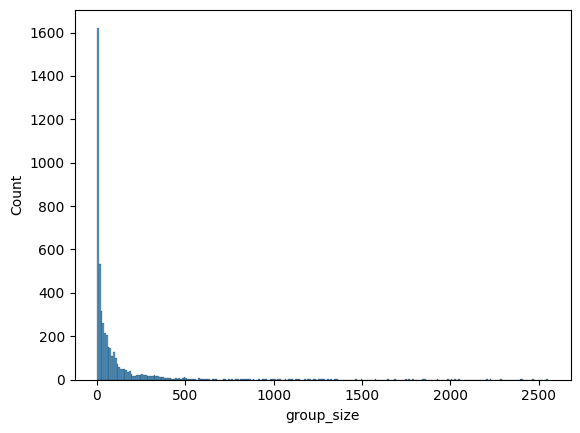

In [14]:
sns.histplot(data=df_cal_year_grouped,
             x='group_size');

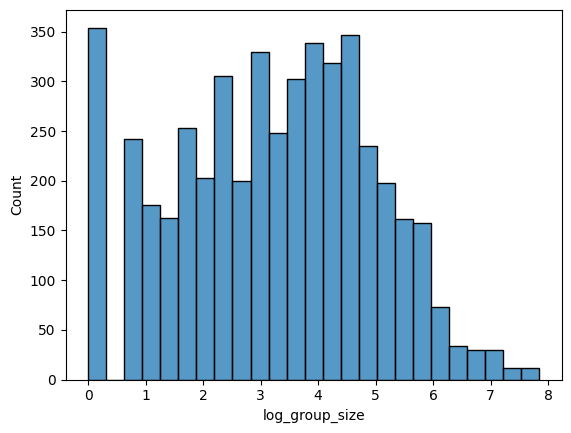

In [15]:
sns.histplot(data=df_cal_year_grouped,
             x='log_group_size');

In [16]:
df_9month_grouped = (grouped9
                       .groupby(['rolling_window', 'township_code', 'class'])
                       .size().reset_index(name='group_size')
                       .assign(data_source='9_month'))

df_12month_grouped = (grouped12
                      .groupby(['rolling_window', 'township_code', 'class'])
                      .size().reset_index(name='group_size')
                      .assign(data_source='12_month'))

df_9month_grouped['log_group_size'] = np.log(df_9month_grouped['group_size'])
df_12month_grouped['log_group_size'] = np.log(df_12month_grouped['group_size'])


df_group_size = pd.concat([df_9month_grouped,
                           df_12month_grouped])

/home/miwagne/repos/ccao_sales_val/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

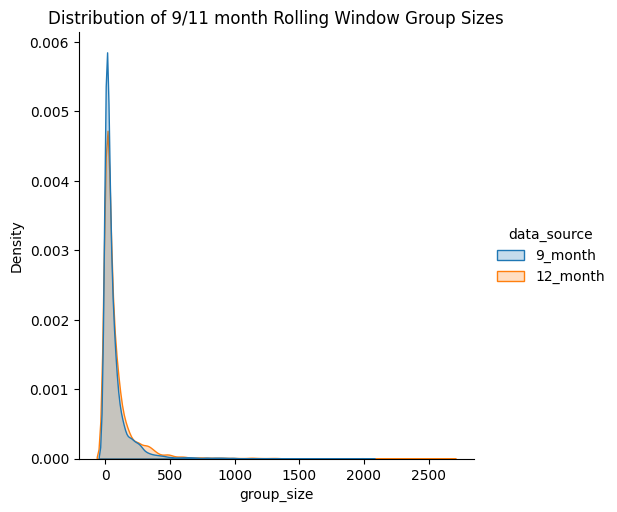

In [58]:
plt.figure(figsize=(12, 8))
sns.displot(data=df_group_size, x="group_size", hue="data_source", kind="kde", fill=True)
plt.title('Distribution of 9/11 month Rolling Window Group Sizes')
plt.show()

/home/miwagne/repos/ccao_sales_val/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

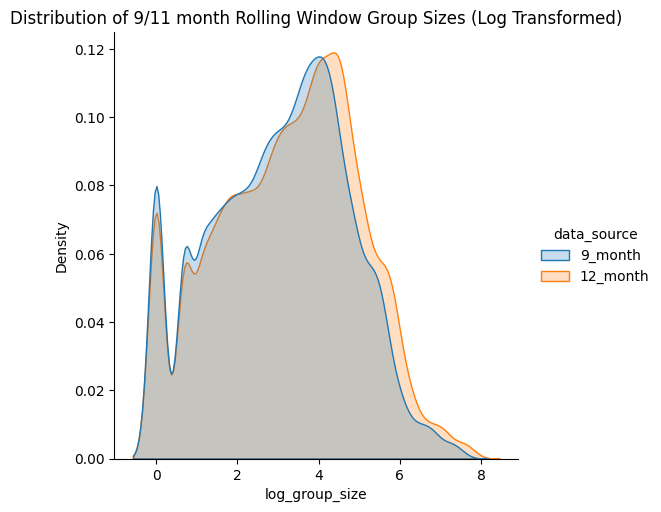

In [22]:
plt.figure(figsize=(12, 8))
sns.displot(data=df_group_size, x="log_group_size", hue="data_source", kind="kde", fill=True)
plt.title('Distribution of 9/11 month Rolling Window Group Sizes (Log Transformed)')
plt.show()

### Number of Outliers

In [6]:
print(f'Total Num of Observations: {df.shape[0]/3}')

Total Num of Observations: 131325.0


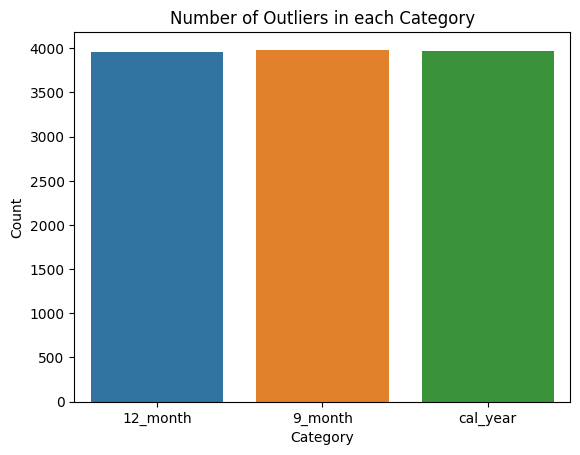

In [7]:
# Create the bar chart using Seaborn
sns.barplot(x='data_source', 
            y='sv_is_outlier', 
            data=df.groupby('data_source')['sv_is_outlier'].sum().reset_index())

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of Outliers in each Category');

## Outliers Unique to Methodology

In [8]:
pivot_df = df.pivot(index='meta_sale_document_num', columns='data_source', values='sv_is_outlier')
pivot_df['is_same'] = pivot_df.nunique(axis=1) == 1
pivot_df.columns.name = None
pivot_df = pivot_df.reset_index()
filtered_df = pivot_df[pivot_df['is_same'] == False]

In [9]:
(pivot_df
 .groupby(['12_month', '9_month', 'cal_year'])
 .size().reset_index(name='count')
 .sort_values(by='count', ascending=False))

,12_month,9_month,cal_year,count
0,0,0,0,126613
7,1,1,1,3272
1,0,0,1,523
6,1,1,0,483
2,0,1,0,134
4,1,0,0,122
3,0,1,1,96
5,1,0,1,82


In [111]:
rolling_no_cal_list = (pivot_df[(pivot_df['12_month'] == 1) & 
                                (pivot_df['9_month'] == 1) & 
                                (pivot_df['cal_year'] == 0)]
                                ['meta_sale_document_num']
                                .tolist())


In [113]:
# not flagged in year, but flagged in both 12 and 9 month rolling
rolling_no_cal_list
df[df['meta_sale_document_num'].isin(rolling_no_cal_list)]

,meta_sale_document_num,year,township_code,class,meta_sale_price,meta_sale_date,meta_sale_seller_name,meta_sale_buyer_name,sale_filter_is_outlier,pin,char_bldg_sf,sv_outlier_type,sv_is_autoval_outlier,sv_special_flags,sv_is_outlier,sv_is_ptax_outlier,sv_is_outlier_heuristics,run_id,data_source,rolling_window
703,2306833009,2023,25,203,995000,2023-02-23,MICHAEL KOSMIDIS,COLE A MICHALEK,False,04353080080000,1343.0,Not outlier,False,Home flip sale,0,0,0,2023-07-21_10:06,cal_year,NaN
835,1607047149,2016,70,211,545000,2016-02-23,None,None,False,20154090360000,8880.0,Not outlier,False,Family sale,0,0,0,2023-07-21_10:06,cal_year,NaN
1450,1602208264,2016,35,295,320000,2016-01-22,JOE SALHANI,KASINATH ROUT,False,07243080640000,1331.0,Not outlier,False,Not special,0,0,0,2023-07-21_10:06,cal_year,NaN
1772,2009239078,2020,73,211,1765000,2020-03-20,GREGORY N SHEPPARD,GARAN M GEIST,False,14171020020000,5327.0,Not outlier,False,Not special,0,0,0,2023-07-21_10:06,cal_year,NaN
2136,1601447109,2016,16,203,140000,2016-01-12,STEVEN M LEHNER,SIEW-LOON POR,False,08271100200000,1232.0,Not outlier,False,Not special,0,0,0,2023-07-21_10:06,cal_year,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443770,1705847014,2017,13,295,80000,2017-02-13,THE BANK OF NEW YORK MELL,REIMEX LLC - CAPITAL,False,28314010840000,1661.0,Home flip sale (low),False,Home flip sale,1,0,1,2023-07-24_12:26,12_month,201702.0
5448062,2031821323,2020,77,203,950000,2020-09-02,JEREMY KIRK,THOMAS M BLASER,False,13363220150000,1713.0,Anomaly (high),False,Not special,1,0,1,2023-07-24_12:26,12_month,202009.0
5451374,1423216013,2014,73,211,1551000,2014-08-04,KIM E COOK,MELROSE PROP LLC,False,14213130290000,2400.0,Home flip sale (high),False,Home flip sale,1,0,1,2023-07-24_12:26,12_month,201408.0
5452250,1410456005,2014,35,295,315000,2014-03-28,Nick Ibrahim,John Lawson,False,07222030350000,1475.0,Home flip sale (high),False,Home flip sale,1,0,1,2023-07-24_12:26,12_month,201403.0


## Outlier Type Distribution

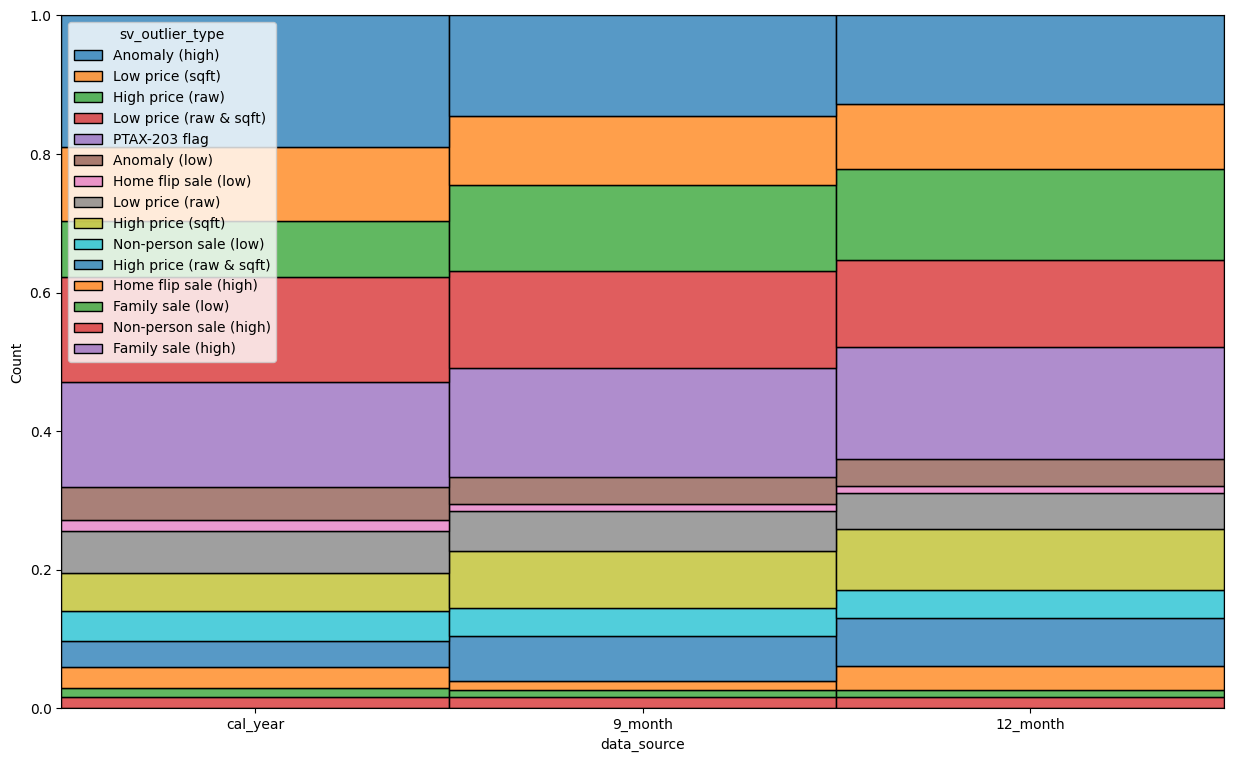

In [12]:
plt.figure(figsize=(15,9))
sns.histplot(data=df[df['sv_is_outlier'] == 1], x='data_source', hue='sv_outlier_type', 
             multiple='fill',
             palette='tab10')
plt.show()

/home/miwagne/repos/ccao_sales_val/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


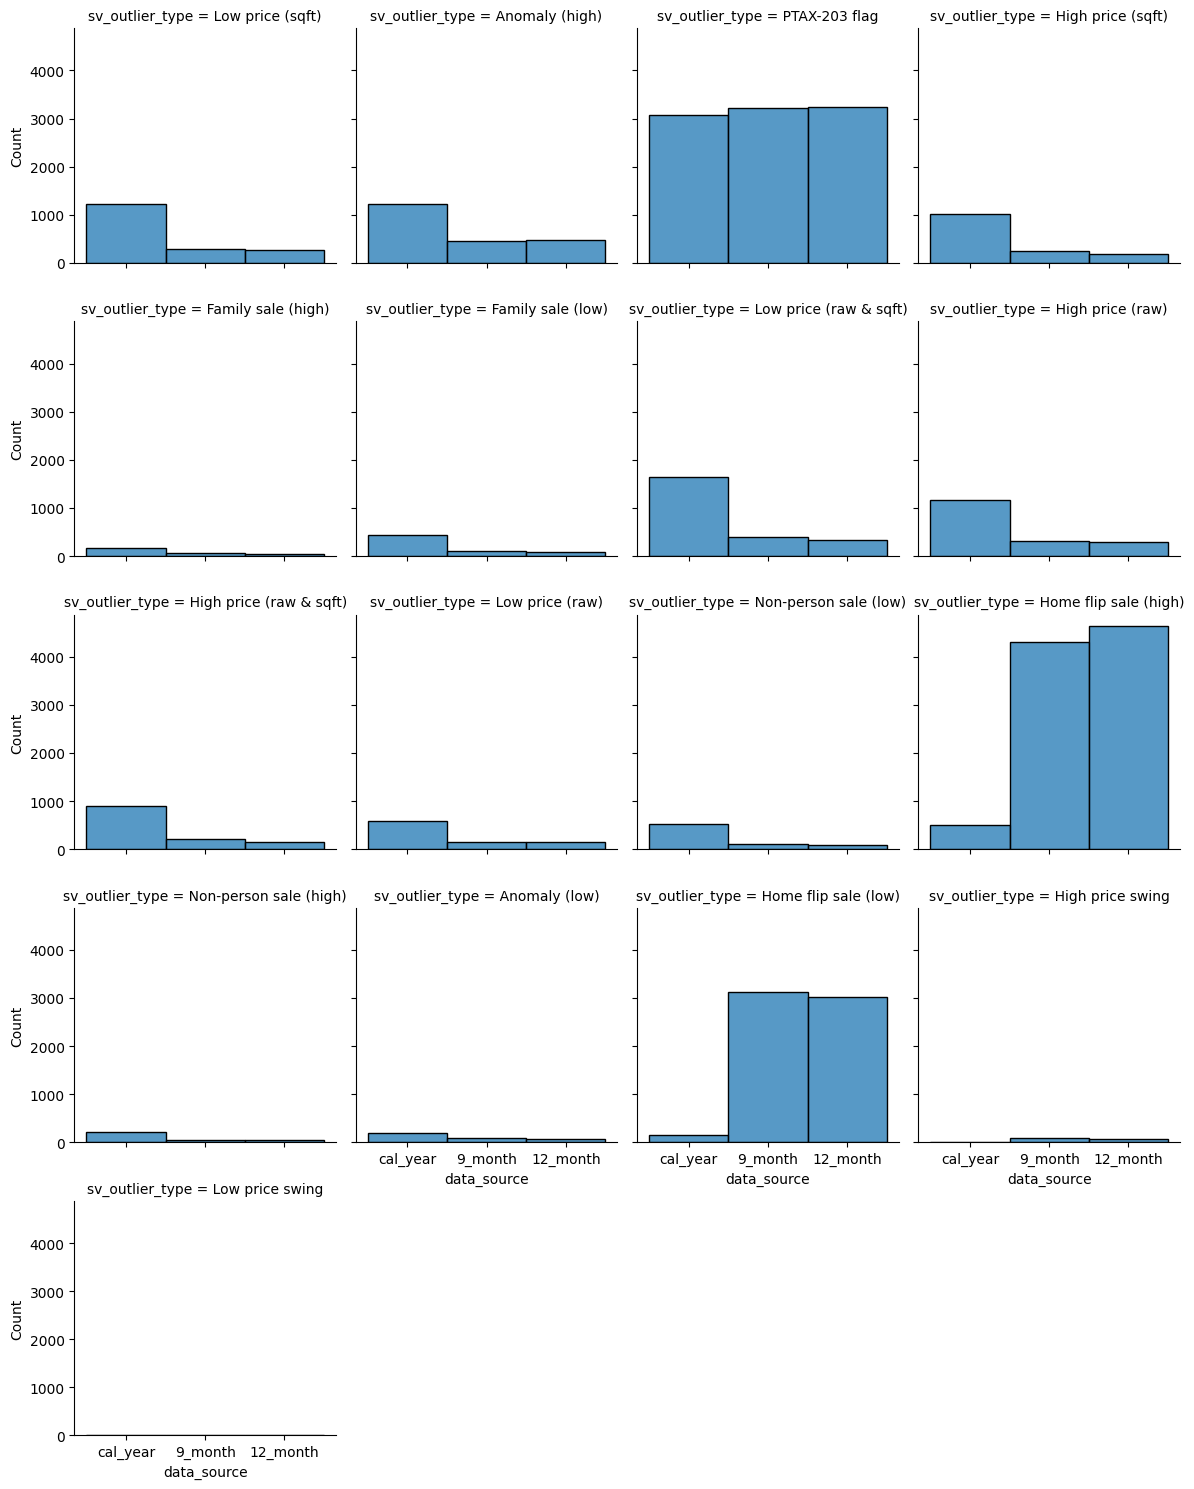

In [127]:
g = sns.FacetGrid(df[df['sv_is_outlier'] == 1], col='sv_outlier_type', col_wrap=4)
g.map(sns.histplot, 'data_source')